# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [7]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

[2017-06-29 21:53:06,531] Making new env: CartPole-v0


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [8]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [9]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [10]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [18]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [19]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
#             env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 8.0 Training loss: 1.0385 Explore P: 0.9992
Episode: 2 Total reward: 35.0 Training loss: 1.1778 Explore P: 0.9958
Episode: 3 Total reward: 48.0 Training loss: 1.1206 Explore P: 0.9910
Episode: 4 Total reward: 17.0 Training loss: 1.1630 Explore P: 0.9894
Episode: 5 Total reward: 21.0 Training loss: 1.3848 Explore P: 0.9873
Episode: 6 Total reward: 37.0 Training loss: 1.2256 Explore P: 0.9837
Episode: 7 Total reward: 17.0 Training loss: 1.2755 Explore P: 0.9820
Episode: 8 Total reward: 24.0 Training loss: 1.5437 Explore P: 0.9797
Episode: 9 Total reward: 41.0 Training loss: 1.3454 Explore P: 0.9757
Episode: 10 Total reward: 20.0 Training loss: 1.3791 Explore P: 0.9738
Episode: 11 Total reward: 37.0 Training loss: 1.4031 Explore P: 0.9703
Episode: 12 Total reward: 24.0 Training loss: 1.7431 Explore P: 0.9680
Episode: 13 Total reward: 12.0 Training loss: 1.5679 Explore P: 0.9668
Episode: 14 Total reward: 26.0 Training loss: 1.0879 Explore P: 0.9643
Episode: 15 Tota

Episode: 121 Total reward: 12.0 Training loss: 63.6177 Explore P: 0.7689
Episode: 122 Total reward: 19.0 Training loss: 183.1429 Explore P: 0.7675
Episode: 123 Total reward: 15.0 Training loss: 127.9556 Explore P: 0.7664
Episode: 124 Total reward: 9.0 Training loss: 2.0824 Explore P: 0.7657
Episode: 125 Total reward: 27.0 Training loss: 146.7881 Explore P: 0.7636
Episode: 126 Total reward: 46.0 Training loss: 2.5721 Explore P: 0.7602
Episode: 127 Total reward: 18.0 Training loss: 268.4084 Explore P: 0.7588
Episode: 128 Total reward: 46.0 Training loss: 95.6924 Explore P: 0.7554
Episode: 129 Total reward: 11.0 Training loss: 59.2765 Explore P: 0.7546
Episode: 130 Total reward: 10.0 Training loss: 70.7778 Explore P: 0.7538
Episode: 131 Total reward: 9.0 Training loss: 2.3832 Explore P: 0.7532
Episode: 132 Total reward: 11.0 Training loss: 209.0103 Explore P: 0.7523
Episode: 133 Total reward: 13.0 Training loss: 288.7385 Explore P: 0.7514
Episode: 134 Total reward: 10.0 Training loss: 83.

Episode: 234 Total reward: 25.0 Training loss: 60.4453 Explore P: 0.6486
Episode: 235 Total reward: 16.0 Training loss: 28.7133 Explore P: 0.6476
Episode: 236 Total reward: 17.0 Training loss: 1.7077 Explore P: 0.6465
Episode: 237 Total reward: 32.0 Training loss: 106.5713 Explore P: 0.6445
Episode: 238 Total reward: 18.0 Training loss: 1.8749 Explore P: 0.6433
Episode: 239 Total reward: 40.0 Training loss: 28.0195 Explore P: 0.6408
Episode: 240 Total reward: 24.0 Training loss: 1.2273 Explore P: 0.6393
Episode: 241 Total reward: 13.0 Training loss: 1.3413 Explore P: 0.6385
Episode: 242 Total reward: 10.0 Training loss: 67.2596 Explore P: 0.6379
Episode: 243 Total reward: 13.0 Training loss: 1.2099 Explore P: 0.6370
Episode: 244 Total reward: 11.0 Training loss: 36.8004 Explore P: 0.6363
Episode: 245 Total reward: 10.0 Training loss: 33.5938 Explore P: 0.6357
Episode: 246 Total reward: 13.0 Training loss: 45.1122 Explore P: 0.6349
Episode: 247 Total reward: 13.0 Training loss: 1.5385 E

Episode: 356 Total reward: 9.0 Training loss: 49.0675 Explore P: 0.5404
Episode: 357 Total reward: 14.0 Training loss: 0.9271 Explore P: 0.5397
Episode: 358 Total reward: 19.0 Training loss: 31.9532 Explore P: 0.5387
Episode: 359 Total reward: 14.0 Training loss: 1.0333 Explore P: 0.5380
Episode: 360 Total reward: 10.0 Training loss: 29.7812 Explore P: 0.5374
Episode: 361 Total reward: 28.0 Training loss: 0.9257 Explore P: 0.5359
Episode: 362 Total reward: 12.0 Training loss: 13.5944 Explore P: 0.5353
Episode: 363 Total reward: 12.0 Training loss: 29.9523 Explore P: 0.5347
Episode: 364 Total reward: 8.0 Training loss: 47.4009 Explore P: 0.5343
Episode: 365 Total reward: 11.0 Training loss: 0.8076 Explore P: 0.5337
Episode: 366 Total reward: 10.0 Training loss: 16.0632 Explore P: 0.5332
Episode: 367 Total reward: 21.0 Training loss: 13.5598 Explore P: 0.5321
Episode: 368 Total reward: 10.0 Training loss: 30.4776 Explore P: 0.5315
Episode: 369 Total reward: 12.0 Training loss: 41.6287 Ex

Episode: 469 Total reward: 91.0 Training loss: 1.7086 Explore P: 0.2590
Episode: 470 Total reward: 67.0 Training loss: 120.3573 Explore P: 0.2573
Episode: 471 Total reward: 49.0 Training loss: 3.1740 Explore P: 0.2561
Episode: 472 Total reward: 64.0 Training loss: 1.7977 Explore P: 0.2545
Episode: 473 Total reward: 58.0 Training loss: 1.8857 Explore P: 0.2531
Episode: 474 Total reward: 54.0 Training loss: 117.1221 Explore P: 0.2518
Episode: 475 Total reward: 72.0 Training loss: 1.1770 Explore P: 0.2501
Episode: 476 Total reward: 54.0 Training loss: 2.3712 Explore P: 0.2488
Episode: 477 Total reward: 55.0 Training loss: 1.7560 Explore P: 0.2475
Episode: 478 Total reward: 67.0 Training loss: 1.2904 Explore P: 0.2459
Episode: 479 Total reward: 106.0 Training loss: 1.2291 Explore P: 0.2434
Episode: 480 Total reward: 86.0 Training loss: 139.2665 Explore P: 0.2414
Episode: 481 Total reward: 46.0 Training loss: 4.4369 Explore P: 0.2403
Episode: 482 Total reward: 34.0 Training loss: 1.5398 Exp

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [167]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

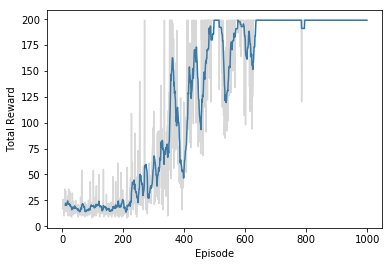

In [181]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [183]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.